In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'
fig_dir = proj_dir+'/Streambed_seepage/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel/'

In [5]:
# run_dir = 'C://WRDAPP/GWFlowModel'
# run_dir = 'F://WRDAPP/GWFlowModel'
# loadpth = run_dir +'/Cosumnes/'



model_ws = proj_dir+'data'

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='MODFLOW-NWT.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [6]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series((m.dis.nper)*15).astype('timedelta64[m]'))[0]

dates_per = pd.date_range(strt_date, end_date, freq = '15min')
dates_stps = pd.date_range(strt_date, end_date, freq = '5min')[:-1]


In [7]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# kstp = np.append([0], np.tile(np.arange(0,3), m.dis.nper)) # with SS period
# kper = np.repeat(np.arange(0,m.dis.nper),m.dis.nstp)

kstp = np.tile(np.arange(0,3), m.dis.nper)
kper = np.repeat(np.arange(0,m.dis.nper),m.dis.nstp)

kstpkper = list(zip(kstp,kper))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

## Sensor data and XS data

In [8]:
df = pd.read_csv(dat_dir+'instream_sensor_latlong.csv',comment='#', engine='python')
df['id_num'] = df.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm = df[df.Type=='Level']
rm_sp = gpd.GeoDataFrame(rm, geometry=gpd.points_from_xy(rm.Longitude,rm.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

rm_teichert = rm_sp[rm_sp.id_num>3]


rm_xs = gpd.read_file(proj_dir+ 'rm_xs/rm_xs.shp')

In [9]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


<AxesSubplot:xlabel='xs_num'>

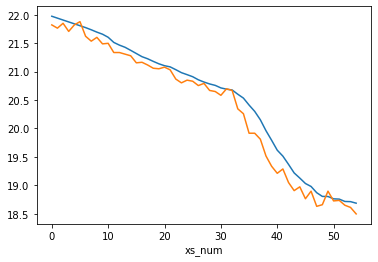

In [10]:
# create summary of XS for creating SFR inputs
# XSg = xs_all.dissolve('xs_num', 'mean')
XSg = xs_all.loc[(xs_all.dist_from_right_m==100).values,:].set_index('xs_num') # use center point for assigning segment data
XSg['iseg'] = XSg.index + 1 # add the segment that corresponds to each cross section

# find minimum value in XS related to thalweg
XSg['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg['z_m_min_cln'] = XSg.z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg.z_m_min_cln.diff().bfill()
XSg['slope'] = z_cln_diff.abs()/m.dis.delr

# fix str bot so all is downward sloping
for i in np.arange(len(XSg)-1,-1,-1):
#     if XSg.z_m.values[i] >= XSg.z_m.values[i-1]:
#         XSg.z_m_min.values[i] = XSg.z_m_min.values[i-1] - XSg.slope.values[i]*delc
# fill NAs due to rolling mean
    if XSg.z_m_min_cln.isna()[i]:
        XSg.z_m_min_cln.values[i] = XSg.z_m_min_cln.values[i + 1] + XSg.slope.values[i]*m.dis.delr[i]

        
# plot, large spike in top elevation causes discontinuity
# plt.plot(m.dis.top.array[0,:])
# plt.plot(m.dis.botm.array[0,0,:])

XSg.z_m_min_cln.plot()
XSg.z_m_min.plot()
# XSg.slope.plot(secondary_y = True)

In [11]:
rm_teichert['Easting'] = rm_teichert.geometry.x
rm_teichert['Northing'] = rm_teichert.geometry.y
rm_poly = rm_teichert.copy()
# buffer sensor points for joining
rm_poly.geometry = rm_poly.geometry.buffer(50)
# correspond XS to sensors
rm_elev = gpd.sjoin(xs_all, rm_poly, how='inner',lsuffix='xs', rsuffix='rm')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [12]:
rm_elev['dist'] = np.sqrt((rm_elev.Easting_xs - rm_elev.Easting_rm)**2 + (rm_elev.Northing_xs - rm_elev.Northing_rm)**2)
mindists = rm_elev.groupby('xs_num').min().dist
# rm_elev.columns
rm_elev_final = rm_elev.set_index(['xs_num','dist']).loc[list(zip(mindists.index, mindists.values))]
# join with XS minimum and slope data
rm_elev_final = rm_elev_final.join(XSg[['z_m_min','slope']])

# field data with measurements
field = pd.read_excel(dat_dir+'Field_measurements.xlsx',sheet_name='Summarized').rename(columns={'Site':'Sensor'})
rm_elev_final = rm_elev_final.join(field.set_index('Sensor'),on='Sensor')

# rm_elev_final['height_above_thalweg_m'] = rm_elev_final.z_m - rm_elev_final.z_m_min
rm_elev_final['height_above_thalweg_m'] = rm_elev_final['Height above thalweg (ft)']  * 0.3048
# sensor height above thalweg
rm_elev_final['sensor_height_m'] = rm_elev_final.z_m_min + rm_elev_final.height_above_thalweg_m

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_11300\2766180489.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  mindists = rm_elev.groupby('xs_num').min().dist


In [13]:
FLD = pd.read_csv(dat_dir+'FLD.csv', parse_dates=['DATE TIME'], na_values='---')
ANU = pd.read_csv(dat_dir+'ANU.csv', parse_dates=['DATE TIME'], na_values='---')


In [14]:
baro = pd.concat((FLD,ANU)).pivot(columns='STATION_ID',values='VALUE',index='DATE TIME')
# resample to hour for consistent units
baro = baro.resample('H').mean()
# convert from inches to meters
baro = (baro/12) * 0.3048
baro = baro.resample('15min').ffill()

In [15]:
lvl = pd.read_csv(dat_dir+'Stream_level_m_temp_C_long.csv', parse_dates=['dt'])
lvl = lvl[lvl.param=='LEVEL']
# lvl.loc[lvl.value>9,'value'] -= 9.5
# lvl = lv.pivot(columns = 'site_nam',values='value', index='dt')

# adjust level data for uniform baro pressure
lvl = lvl.pivot(columns='site_nam',values='value',index='dt')
lvl.loc[:,(lvl.mean()>9.5)] -= 9.5
lvl = lvl.melt(ignore_index=False).dropna()

# join with barometric pressure by date
lvl = lvl.join(baro, on='dt')
lvl['lvl_adj'] = lvl.value - lvl.FLD

In [16]:
stage = lvl.join(rm_elev_final[['height_above_thalweg_m','Sensor']].set_index('Sensor'), on='site_nam')
stage = stage.dropna(subset='height_above_thalweg_m')
# calculate stage with height above thalweg
stage['stage_m'] = stage.lvl_adj + stage.height_above_thalweg_m

In [17]:
# hk = m.lpf.hk.array
# hk_limit = np.quantile(hk,0.87)
# hk_high = np.zeros(hk.shape)
# hk_high[hk>hk_limit]=1
# hk_high[:,(m.lak.lakarr.array==1)[0,0,:,:]]+=2

In [18]:
# for n in [0,1,5,8,12]:
#     plt.imshow(hk_high[n])
#     plt.show()


In [19]:
sfr_dir = gwfm_dir+'/SFR_data/'
# grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


In [20]:
# m.dis.nper # perlen, nstp, tsmult, start_datetime
# num_days = np.cumsum(m.dis.perlen.array).astype('timedelta64[D]')
# spd_dates = pd.to_datetime(m.dis.start_datetime) + num_days - np.ones(1).astype('timedelta64[D]')

# m.dis.nstp.array
# m.dis.tsmult.array

In [21]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]


In [22]:
# match sensors to nearest XS point to estimate elevation above thalweg

In [23]:
grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = pd.DataFrame(grid_sfr.set_index(['row','column'])[['rchlen','strtop']])
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(model_ws+'/MF.sfr.out')
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    cmm2cfs = 1/((0.3048**3)*60) # cubic meters per minute to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmm2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmm2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmm2cfs
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [24]:
sfrdf_plot = clean_sfr_df(model_ws)
# gage_file = glob.glob(model_ws+'/*.go')
# gage_file[0]

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\flopy\utils\sfroutputfile.py:174: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = self.pd.read_csv(
b'Skipping line 69: expected 18 fields, saw 23\nSkipping line 132: expected 18 fields, saw 23\nSkipping line 195: expected 18 fields, saw 23\nSkipping line 258: expected 18 fields, saw 23\nSkipping line 321: expected 18 fields, saw 23\nSkipping line 384: expected 18 fields, saw 23\nSkipping line 447: expected 18 fields, saw 23\nSkipping line 510: expected 18 fields, saw 23\nSkipping line 573: expected 18 fields, saw 23\nSkipping line 636: expected 18 fields, saw 23\nSkipping line 699: expected 18 fields, saw 23\nSkipping line 762: expected 18 fields, saw 23\nSkipping line 825: expected 18 fields, saw 23\nSkipping line 888: expected 18 fields, saw 23\nSkipping line 951: expected 18 fields, saw 23\nSkipping line 1014: expected 18 fields,

In [25]:
# n=2
# fig,ax = plt.subplots(1,2,figsize=(10,3))
# sfrdf_plot[sfrdf_plot.segment==n].plot(y='Qin_cfs',ax = ax[0])
# sfrdf_plot[sfrdf_plot.segment==n].plot(y='Qout_cfs',ax = ax[0])

# sfrdf_plot[sfrdf_plot.segment==n].plot(y='Qaquifer_cfs',ax = ax[1])
# plt.show()
# sfrdf_plot[sfrdf_plot.segment==3].plot(y='Qin_cfs')

In [26]:
# n=0
# for n in np.arange(0,len(rm_xs)):
#     sfrdf_plot[sfrdf_plot.segment==rm_xs.iseg[n]].plot(y='Qin_cfs')

In [27]:
# mcc_plt = mcc_out.join(mcc_d)

# fig,ax=plt.subplots(figsize=(8,4))
# mcc_plt.plot(y='flow_sim_cfs',label='MCC Simulated',ax=ax)

# mcc_plt.plot(y='flow_cfs',label='MCC Observed',ax=ax, linestyle='--')

# mb.plot(y='flow_cfs',label= 'MB Observed', ax=ax)
# under simulating flow most likely because we don't have any runoff
# adding uzf to remove excess recharge to stream would most likely bring up the peak flows

In [28]:
def read_sfr_gage(xs_num):
    gagenam = model_ws+'/MF_gage_' + str(xs_num) + '.go'
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:]

    gage = gage.dropna(axis=1)
    gage.columns = cols
    cmm2cfs = 1/((0.3048**3)*60) # cubic meters per minute to cfs
    # convert from m3/day to cfs
    gage['Stream_leakage'] = gage['Conductance']* gage['HeadDiff'] /(0.3048**3)/86400
    gage['Stream_leakage_cfs'] = gage['Stream_leakage'] * cmm2cfs
    gage['Flow_cfs']  = gage['Flow'] * cmm2cfs
    gage['Time'] = strt_date + gage.Time.values.astype('timedelta64[m]')
    gage = gage.set_index('Time')
    return(gage)


In [29]:
stage_cln = stage[stage.lvl_adj>0.2].pivot(columns='site_nam',values='lvl_adj').dropna(axis=0)
# stage_cln

<AxesSubplot:xlabel='dt'>

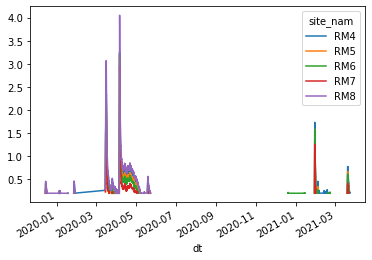

In [30]:
stage[stage.lvl_adj>0.2].pivot(columns='site_nam',values='lvl_adj').plot()

In [31]:
stage_m = stage[(stage.index>dt_ref.dt.min())&(stage.index<dt_ref.dt.max())]

Calibration should be done with change in stage rather than absolute values. I can create an offset to align values better as well. The first few XS seems to represent the observations well, but it appears that there may be some baseflow prevent a decline in flow downstream, starting at XS25 where the simulated stage appears to oscillate following a decline. When I check heads the first time there was a mound causing some baseflow but even after correcting the higher streamflow seems to stay. It starts with the flow leaving XS 21 with oscillations (1000 to 1500 cmm)

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'Qwt',
       'delUzstor', 'gw_head', 'kstpkper', 'k', 'i', 'j', 'rchlen', 'strtop',
       'Total distance (m)', 'Qin_cfs', 'Qout_cfs', 'Qaquifer_cfs'],
      dtype='object')

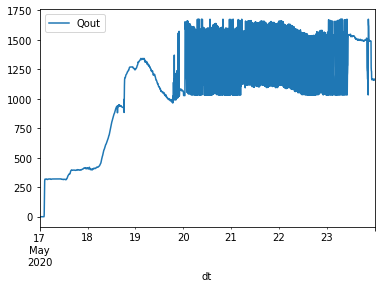

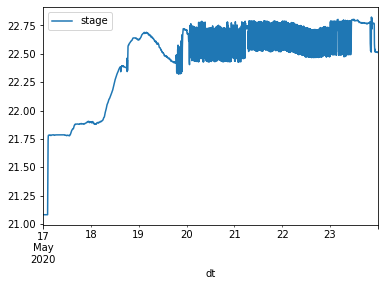

In [32]:
# sfrdf_plot[sfrdf_plot.segment==2].plot(y='Qaquifer')
sfrdf_plot[sfrdf_plot.segment==21].plot(y='Qout')
# 
# sfrdf_plot[sfrdf_plot.segment==21].plot(y='Qaquifer')
sfrdf_plot[sfrdf_plot.segment==22].plot(y='stage')
# sfrdf_plot[sfrdf_plot.segment==21].plot(y=['Qovr','Qprecip','Qet'])
sfrdf_plot.columns
# the listing file confirmed Segment 21 was having non-convergence issues

the obs data set for UCODE will either be absolute observed stage or change in stage. And UCODE can read the absolute stage directly from the gage file, but would need an additional post-processor script to write out a change in stage file.

25


<AxesSubplot:xlabel='dt'>

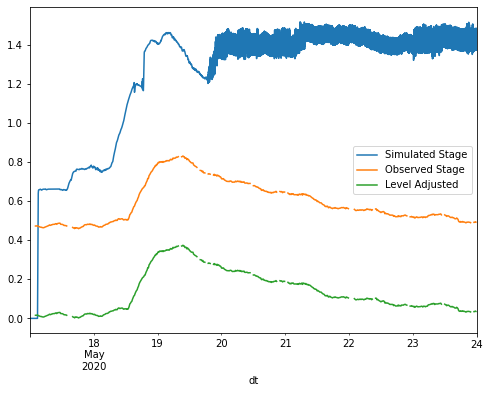

In [33]:
n=2 # have 0 through 4
print(rm_xs.iseg[n])
fig,ax=plt.subplots(figsize=(8,6))
read_sfr_gage(rm_xs.iseg[n]).plot(y='Depth', ax=ax, label='Simulated Stage')
stage_m.loc[stage_m.site_nam==rm_xs.Sensor[n]].plot(y='stage_m', ax=ax, label='Observed Stage')
stage_m.loc[stage_m.site_nam==rm_xs.Sensor[n]].plot(y='lvl_adj', ax=ax, label='Level Adjusted')

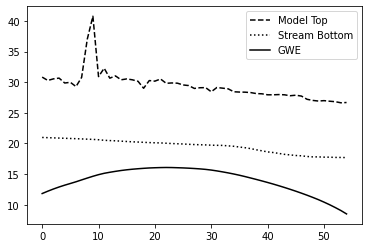

In [36]:
spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
head = hdobj.get_data(spd_hd)[0][0]
plt.plot(m.dis.top.array[0],label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

plt.plot(head,label = 'GWE',  color='black')

plt.legend()

<AxesSubplot:xlabel='Time'>

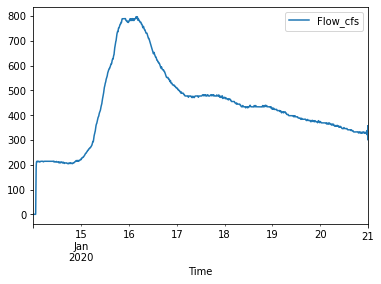

In [332]:
# read_sfr_gage(rm_xs.iseg[0]).plot(y='Stream_leakage_cfs')
read_sfr_gage(rm_xs.iseg[0]).plot(y='Flow_cfs')

# read_sfr_gage(rm_xs.iseg[0]).plot(y='HeadDiff')

# Graphics for ISMAR 2022

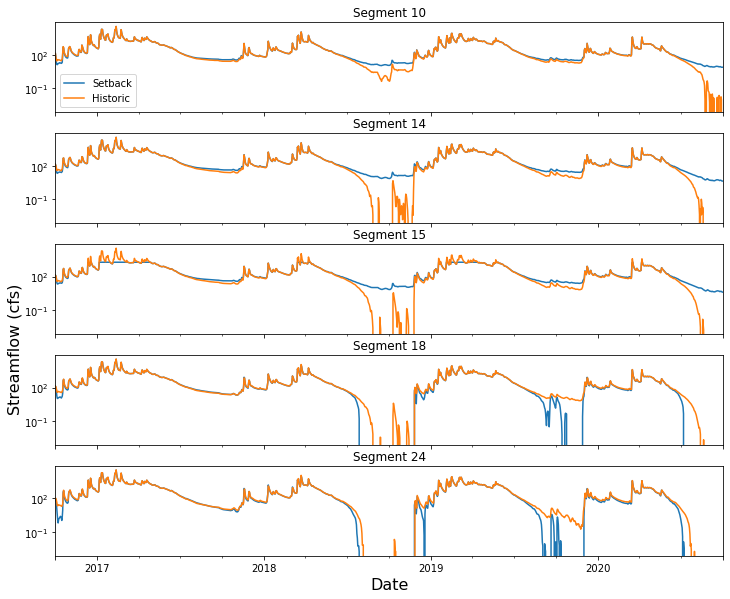

In [292]:
# start flow, before diversion, after diversion, after floodplain, midway to end, end
segments2check = np.asarray([10,14, 15, 18,24])
fig,ax=plt.subplots(len(segments2check),1,figsize=(10,8),sharex='col', sharey='col')
fig.tight_layout()

for i,nseg in enumerate(segments2check):
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_setback',ax=ax[i],
                                                                         label='Setback',linestyle='-',legend=False)
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_historic',ax=ax[i],
                                                                     label='Historic',linestyle='-',legend=False)
    ax[i].set_title('Segment '+str(nseg))
# sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_diff',ax=ax[0],
#                                                                      label=str(nseg),linestyle='--')
ax[0].legend()
ax[0].set_yscale("log", base=10)

# ax[0].set_xlim('2019-01-01','2019-07-01')
fig.text(-0.02,0.3,'Streamflow (cfs)',rotation='vertical',size=16)
plt.xlabel('Date',size=16)

plt.savefig(plt_dir+'selected_streamflow_logscale.png',dpi=600,bbox_inches='tight')

Text(0.5, 50.99999999999994, 'Date')

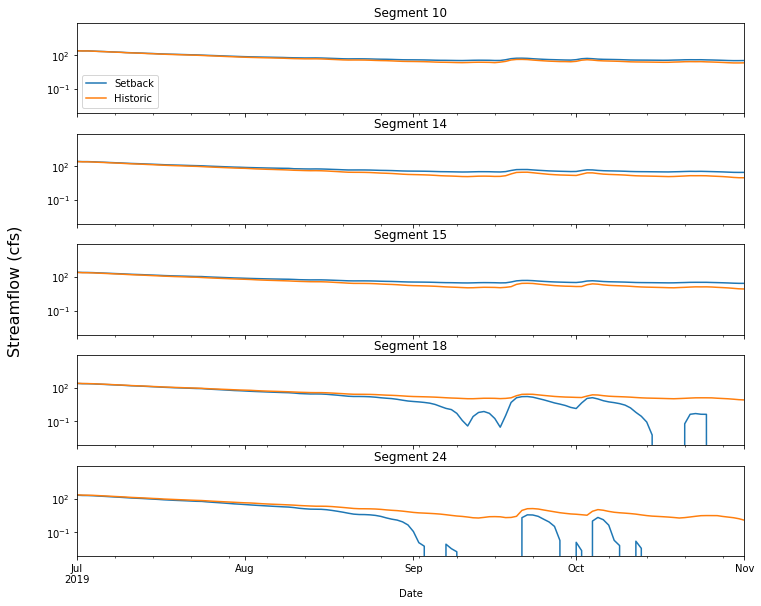

In [291]:
# start flow, before diversion, after diversion, after floodplain, midway to end, end
segments2check = np.asarray([10, 14, 15, 18,24])
fig,ax=plt.subplots(len(segments2check),1,figsize=(10,8),sharex='col',sharey='col')
fig.tight_layout()

for i,nseg in enumerate(segments2check):
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_setback',ax=ax[i],
                                                                         label='Setback',linestyle='-',legend=False)
    sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_historic',ax=ax[i],
                                                                     label='Historic',linestyle='-',legend=False)
    ax[i].set_title('Segment '+str(nseg))
# sfrdf_plot.loc[(sfrdf_plot.segment ==nseg)&(sfrdf_plot.reach==1)].plot(y='Qin_cfs_diff',ax=ax[0],
#                                                                      label=str(nseg),linestyle='--')
ax[0].legend()
ax[0].set_xlim('2019-07-01','2019-11-01')
# ax[0].set_ylim(0,200)
ax[0].set_yscale("log", base=10)
fig.text(-0.05,0.4, 'Streamflow (cfs)', rotation='vertical',size=16)
plt.xlabel('Date')